In [1]:
import pymysql
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import time

In [2]:
def get_ts_map_start_end(match_id=None): # get map start and end times from pickle
    '''
    parameters: match_id: int

    returns:    ts_match_start, ts_map_start, ts_map_end (int, pandas.Series, pandas.Series)
    '''
    # get map start and end time
    path = 'D:\owl-data\pickles'
    file_name = 'OWL_map_start_info'
    timestamps = pd.read_pickle(os.path.join(path, file_name))

    # send error msg if there is no match_id
    if timestamps['esports_match_id'].isin([match_id]).any() == False:
        raise ValueError('there is no match_id in OWL_map_start_info')

    timestamps = timestamps[timestamps['esports_match_id'] == match_id]
    timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
    ts_match_start = timestamps['time_gamestart'].min()

    ts_map_start = timestamps['time_gamestart']
    ts_map_start.reset_index(drop=True, inplace=True)
    ts_map_end = timestamps['time_gameresult']
    ts_map_end.reset_index(drop=True, inplace=True)
    
    return ts_match_start, ts_map_start, ts_map_end

In [3]:
def get_team_info(match_id=None):
    '''
    parameters: match_id: int

    returns:    team_one_name, team_one_id, team_two_name, team_two_id (str, int, str, int)
    '''
    # get team_names
    path = 'D:\owl-data'
    file_name = 'OWL_match_results.csv'
    match_results = pd.read_csv(os.path.join(path, file_name))
    match_results = match_results[match_results['esports_match_id'] == match_id][['team_one_name', 'team_two_name']]
    match_results.reset_index(inplace=True)
    team_one_name = match_results.loc[0, 'team_one_name']
    team_two_name = match_results.loc[0, 'team_two_name']
    
    # get team_ids
    esports_team_id = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'df_esports_team_id.pickle'))
    team_one_id = int(esports_team_id[esports_team_id['team_name'] == team_one_name]['team_id'])
    team_two_id = int(esports_team_id[esports_team_id['team_name'] == team_two_name]['team_id'])

    return team_one_name, team_one_id, team_two_name, team_two_id

In [4]:
team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=34912)

In [5]:
# Get event timestamps
def getEvents(match_id=None, ssg=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # table names from mysql db
    db_name = 'esd_phs'

    # send query
    table_id = f'match_{match_id}'

    if team_id == 0: # default
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' ORDER BY `time`;"
    else: # where designated team_id
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' AND `esports_team_id` = '{team_id}' ORDER BY `time`;"

    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time in ms
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)

    # get map start times and end times
    map_start_times = ts_map_start - ts_match_start # set match start time as 0
    map_end_times = ts_map_end - ts_match_start # set match start time as 0

    # groupby df
    df2 = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    df2['time'] = pd.to_numeric(df2['time'])
    df2['time'] = df2['time'] / 1000 # ms to s
    df2['time'] = df2['time'] - ts_match_start # set match start time as 0

    sum_df = df2.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps
    
    sum_df = sum_df.droplevel(level='short_stat_guid')
    sum_df = sum_df.reset_index(level='time')
    sum_df['dx'] = sum_df['amount'].diff()
    sum_df['dt'] = sum_df['time'].diff()
    sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
    
    # define event time with threshold
    sum_df['event'] = sum_df['dx'] > threshold # True if dx > threshold
    
    # transform time (int) into UTC datetime
    sum_df['time'] += ts_match_start
    sum_df['time'] = pd.to_datetime(sum_df['time'], unit='s', utc=True)
    
    # resample
    # sum_df = sum_df.resample(interval, on='time').sum()

    return sum_df

In [6]:
def getEvents_alives(match_id=None, team_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    events_lives = getEvents(match_id=match_id, ssg=1136, team_id=team_id)
    events_deaths = getEvents(match_id=match_id, ssg=41, team_id=team_id)
    events_alives = events_lives.merge(events_deaths, how='outer', on='time')
    events_alives['amount_y'].fillna(0, inplace=True)
    events_alives['amount'] = events_alives['amount_x'] - events_alives['amount_y']
    events_alives = events_alives[['time', 'amount']]
    
    return events_alives

In [7]:
def getEvents_teampowerbalance(match_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}

    returns:    events_teampowerbalance (pandas.DataFrame[['time', 'amount_{team_one}', 'amount_{team_two}', 'TPB']])
    '''
    # get team info
    team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=match_id)

    team_one_alives = getEvents_alives(match_id=match_id, team_id=team_one_id)
    team_two_alives = getEvents_alives(match_id=match_id, team_id=team_two_id)
    events_teampowerbalance = team_one_alives.merge(team_two_alives, how='outer', on='time', suffixes=(f'_{team_one_name}', f'_{team_two_name}'))
    events_teampowerbalance['TPB'] = (events_teampowerbalance[f'amount_{team_one_name}'] * events_teampowerbalance[f'amount_{team_one_name}']) - (events_teampowerbalance[f'amount_{team_two_name}'] * events_teampowerbalance[f'amount_{team_two_name}'])

    return events_teampowerbalance

In [8]:
def getEvents_finalblows(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 44

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [9]:
def getEvents_herodamagedone(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=400):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 400 (float)

    returns:    event_alldamagedone (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 1208 # Hero_Damage_Done

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [15]:
# HDB, FB, TPB
match_id = 34912
stat_lifespan = 'GAME'
events_finalblows = getEvents_finalblows(match_id=match_id, stat_lifespan=stat_lifespan)
events_herodamagedone = getEvents_herodamagedone(match_id=match_id, stat_lifespan=stat_lifespan)
events_TPB = getEvents_teampowerbalance(match_id=match_id, stat_lifespan=stat_lifespan)

# match start timestamps
ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)
ts_match_start = pd.to_datetime(ts_match_start, unit='s', utc=True)
ts_match_start

Timestamp('2020-08-08 11:44:49.006000042+0000', tz='UTC')

In [92]:
# put all relevant stats in single df
df1 = events_TPB[['time', 'TPB']]

df2 = events_herodamagedone[['time', 'dx']]
df2 = df2.rename(columns={'dx':'HDD'})

df3 = events_finalblows[['time', 'dx']]
df3 = df3.rename(columns={'dx':'FB'})

df_TF = df1.merge(df2, how='outer', on='time')
df_TF = df_TF.merge(df3, how='outer', on='time')
display(df_TF)

,time,TPB,HDD,FB
0,2020-08-08 11:44:51.322999954+00:00,0.0,NaN,NaN
1,2020-08-08 11:44:53.401000023+00:00,0.0,NaN,NaN
2,2020-08-08 11:44:55.489000082+00:00,0.0,NaN,NaN
3,2020-08-08 11:44:57.566999912+00:00,0.0,4.000000e+01,NaN
4,2020-08-08 11:44:59.653000116+00:00,0.0,3.097778e+02,NaN
...,...,...,...,...
1696,2020-08-08 13:13:14.536999941+00:00,NaN,-7.275958e-12,0.0
1697,2020-08-08 13:13:16.618999958+00:00,NaN,7.275958e-12,0.0
1698,2020-08-08 13:13:18.701999903+00:00,NaN,-7.275958e-12,0.0
1699,2020-08-08 13:13:20.788000107+00:00,NaN,0.000000e+00,0.0


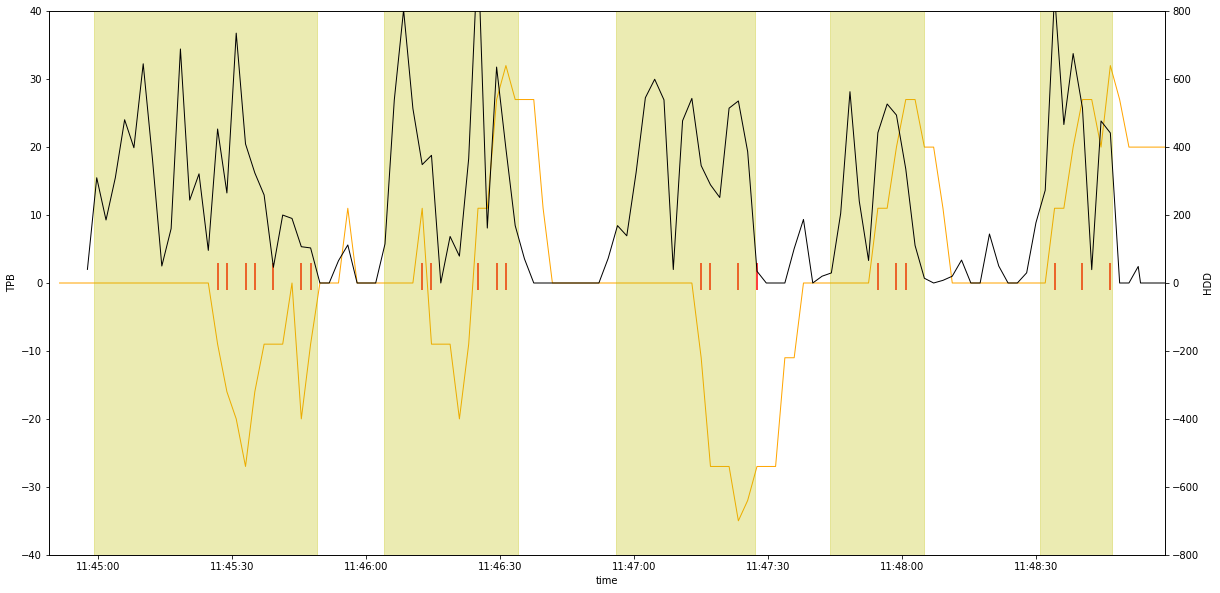

In [93]:
# Plot Team Power Balance
plt.figure(figsize=(20,10))
ax0 = sns.lineplot(x='time', y='TPB', data=df_TF, linewidth=1, color='orange') # plot TPB

plt.eventplot(df_TF[df_TF['FB']>0]['time'], color='red', linelengths=4) # plot FB eventplot

plt.ylim(-40,40)

ax1 = ax0.twinx()
sns.lineplot(x='time', y='HDD', data=df_TF, linewidth=1, color='black', ax=ax1) # plot HDD
plt.ylim(-800, 800)

youtube_video_start = 185
TF_start_time_stamps = [10, 75, 127, 120+55, 180+42] # start: 3:05 6:21 6:47 7:03
TF_end_time_stamps = [60, 105, 158, 180+16, 240-2]

TF_start_time_stamps.extend([480+13-youtube_video_start, 540+51-youtube_video_start, 600+51-youtube_video_start, 660+30-youtube_video_start, 600+120+2-youtube_video_start, 600+120+50-youtube_video_start, 600+180+10-youtube_video_start])
TF_end_time_stamps.extend([540+16-youtube_video_start, 600+21-youtube_video_start, 660+18-youtube_video_start, 660+34-youtube_video_start, 600+120+25-youtube_video_start, 600+120+56-youtube_video_start, 600+180+16-youtube_video_start])

TF_start_time_stamps = pd.to_timedelta(TF_start_time_stamps, unit='s')
TF_end_time_stamps = pd.to_timedelta(TF_end_time_stamps, unit='s')

for t, val in enumerate(TF_start_time_stamps):
    plt.axvspan((ts_match_start + TF_start_time_stamps[t]), (ts_match_start + TF_end_time_stamps[t]), color='y', alpha=0.3)

plt.xlim(ts_match_start + pd.to_timedelta(0, unit='s'), ts_match_start + pd.to_timedelta(250, unit='s'))

plt.show()

(1504, 4) (2795, 3)


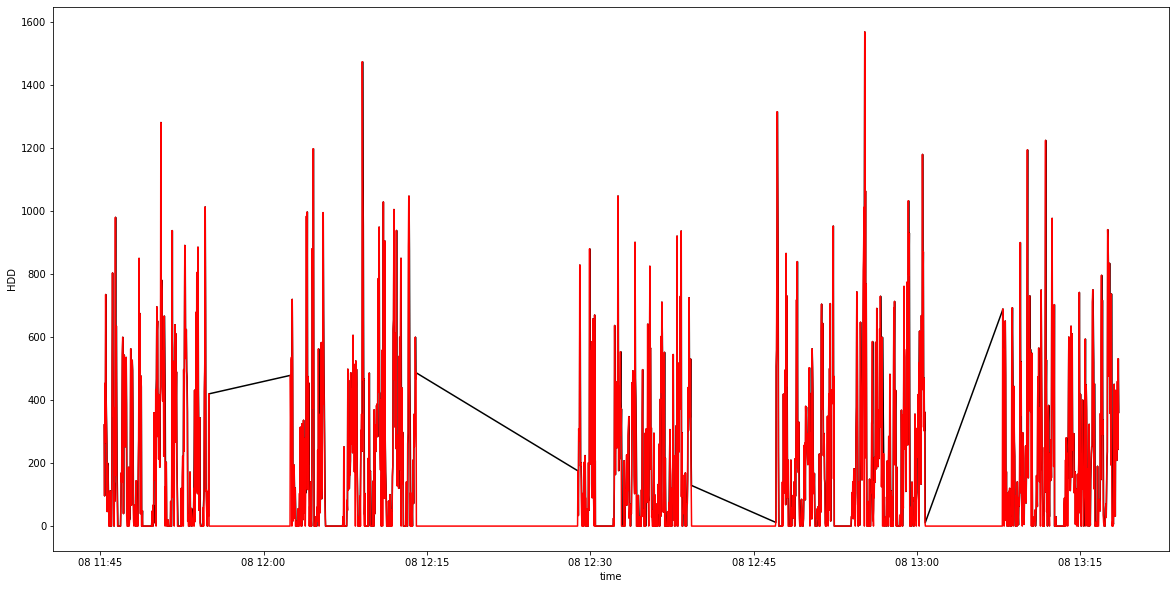

In [95]:
# remove (-) values in HDD/s and FB (it appears when a map starts cuz 'dx' was calculated by diff())
df_TF = df_TF[df_TF['HDD'] >= 0]
df_TF = df_TF[df_TF['FB'] >= 0]

# resampling
resample = df_TF.resample('2s', on='time').sum()
print(df_TF.shape, resample.shape)

# compare original df and resampled df
plt.figure(figsize=(20,10))
sns.lineplot(x='time', y='HDD', data=df_TF, color='black')
sns.lineplot(x='time', y='HDD', data=resample, color='red')

# plt.xlim(ts_match_start + pd.to_timedelta(0, unit='s'), ts_match_start + pd.to_timedelta(650, unit='s'))
# plt.ylim(0,3)

plt.show()

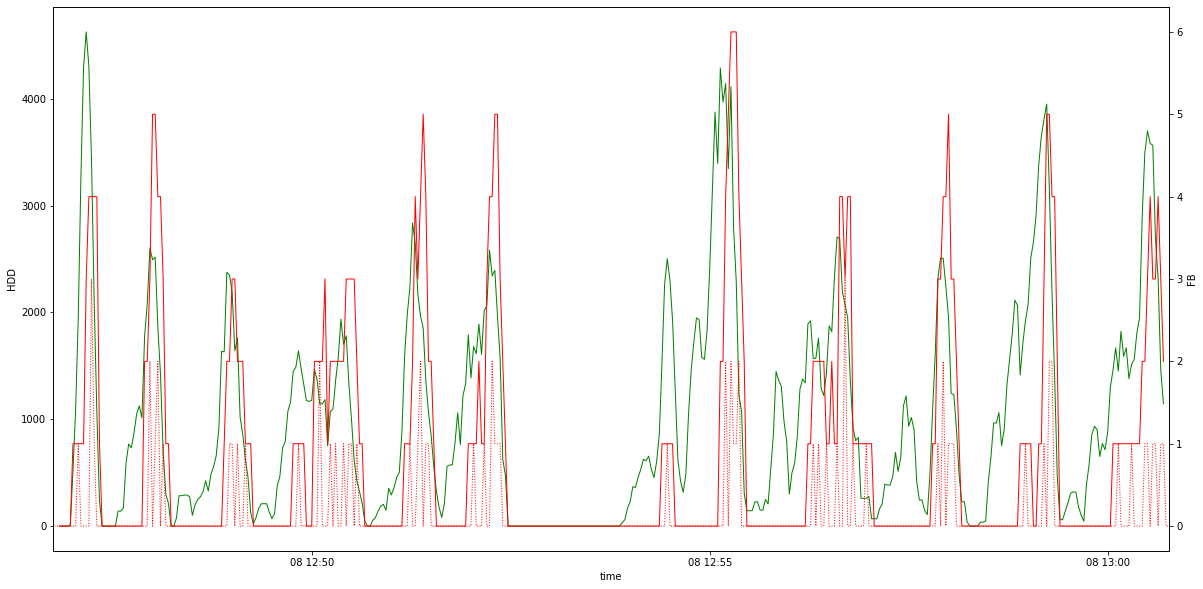

In [102]:
num_map = 3
s0 = resample[pd.to_datetime(ts_map_start[num_map], unit='s', utc=True): pd.to_datetime(ts_map_end[num_map], unit='s', utc=True)]
window=5
rolling = s0.rolling(window, center=True).sum()

plt.figure(figsize=(20,10))
# sns.lineplot(x='time', y='HDD/s', data=s0, color='black')
ax = sns.lineplot(x='time', y='HDD', data=rolling, color='green', linewidth=1)
plt.ylabel('HDD')
ax1 = ax.twinx()
sns.lineplot(x='time', y='FB', data=rolling, color='red', ax=ax1, linewidth=1)
sns.lineplot(x='time', y='FB', data=s0, color='red', ax=ax1, linestyle=':', linewidth=1)
# sns.lineplot(x='time', y='TPB', data=resample, color='orange', ax=ax1, linewidth=1)
plt.ylabel('FB')

# # span
# youtube_video_start = 185
# TF_start_time_stamps = [10, 75, 127, 120+55, 180+42] # start: 3:05 6:21 6:47 7:03
# TF_end_time_stamps = [60, 105, 158, 180+16, 240-2]

# TF_start_time_stamps.extend([480+13-youtube_video_start, 540+51-youtube_video_start, 600+51-youtube_video_start, 660+30-youtube_video_start, 600+120+2-youtube_video_start, 600+120+50-youtube_video_start, 600+180+10-youtube_video_start])
# TF_end_time_stamps.extend([540+16-youtube_video_start, 600+21-youtube_video_start, 660+18-youtube_video_start, 660+34-youtube_video_start, 600+120+25-youtube_video_start, 600+120+56-youtube_video_start, 600+180+16-youtube_video_start])

# TF_start_time_stamps = pd.to_timedelta(TF_start_time_stamps, unit='s')
# TF_end_time_stamps = pd.to_timedelta(TF_end_time_stamps, unit='s')

# for t, val in enumerate(TF_start_time_stamps):
#     plt.axvspan((ts_match_start + TF_start_time_stamps[t]), (ts_match_start + TF_end_time_stamps[t]), color='y', alpha=0.3)

# plt.xlim(ts_match_start + pd.to_timedelta(1000, unit='s'), ts_match_start + pd.to_timedelta(1500, unit='s'))
plt.xlim(pd.to_datetime(ts_map_start[num_map], unit='s', utc=True), pd.to_datetime(ts_map_end[num_map], unit='s', utc=True))
plt.show()

In [98]:
# TF detector
def TF_detector(df):
    is_TF = True
    window = 10 # moving window in second

    '''
    <시작 조건>
    시작 조건 0. TF 중 = False
    시작 조건 1. time > 이전 TF 종료 시간
    시작 조건 2. HDD >= {HDD_threshold=500}
        OR
    시작 조건 3. HDD >= {HDD_threshold=500} 시간 이후, first FB=False 상태로 HDD = 0 생기면 이전 HDD time 제외
    
    시작 조건 3. FB > 0, time - {possible_time_variance=1}
        OR
    시작 조건 4. 

    <종료 조건>
    종료 조건 0. TF 진행 중 = True
    종료 조건 1. FB = 0 이 {no_FB_duration=10}초 이상

    *stagger
    *길어지는 한타
    FB 0 되고 10s동안 추가 킬이 없어야 한타 종료로 인정
    '''
    def parse_by_map():
        
        # get num of map played here
        num_map = 4
        
        # get map start and end times here
        datetime_map_start = []
        datetime_map_end = []

        # parse map
        s0 = resample[pd.to_datetime(ts_map_start[num_map], unit='s', utc=True): pd.to_datetime(ts_map_end[num_map], unit='s', utc=True)]
        
        return df_by_map

    def parse_by_round():
        '''
        if HDD=0 over 30s, ROUND END
        '''
        return df_by_round

    def condition1(df):
        return is_TF1
    def condition2(df):
        return is_TF2
    def condition3(df):
        return is_TF3

    return TF_timestamps # [['time', 'TF_starts', 'TF_ends']] (timestamps of TF starts and ends)
    

In [99]:
'''
우선 kill raster plot & hist plot 기준으로 TF 시간 스탬프를 나눈 뒤,
각 TF에서 발생한 ADD 분포를 구하고, max ADD or scaled ADD 기준으로 특정 threshold를 걸어서 
'''

'\n우선 kill raster plot & hist plot 기준으로 TF 시간 스탬프를 나눈 뒤,\n각 TF에서 발생한 ADD 분포를 구하고, max ADD or scaled ADD 기준으로 특정 threshold를 걸어서 \n'

In [100]:
tf_def_ssg_dict = {'Final |Rpl {0}:Blow:Blows;':44, 'All Damage Done':201, 'Time Played':38, 'Healing Done':465, 'Damage Blocked':675, '|Rpl {0}:Ultimate:Ultimates; Earned':1124, '|Rpl {0}:Ultimate:Ultimates; Used':1125, '|Rpl {0}:Shot:Shots; Fired':1132, 'Hero Damage Done':1208, '|Rpl {0}:Death:Deaths;':41}
tf_def_ssg_dict.values()

dict_values([44, 201, 38, 465, 675, 1124, 1125, 1132, 1208, 41])